### Task2: Линейная регрессия, метод градиентного спуска.

#### Импорт необходимых библиотек

In [329]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import abc
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import (
    check_scalar, check_X_y, check_array, check_random_state, check_is_fitted
)
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils.estimator_checks import check_estimator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from math import ceil
from numbers import Integral, Real
import numpy as np

import warnings
warnings.filterwarnings('ignore')

### Разведочный анализ

#### Набор данных

Был выбран датасет с информацией об автомобилях, которые продавались в Польше. Набор содержит данные о марке, модели, поколении, годе выпуска, пробеге, местоположении и цене машины, а также о типе и об объеме двигателя.

In [330]:
df = pd.read_csv("Car_Prices_Poland_Kaggle.csv")

df.head()

Unnamed: 0  mark  model generation_name  year  mileage  vol_engine    fuel  \
0           0  opel  combo      gen-d-2011  2015   139568        1248  Diesel   
1           1  opel  combo      gen-d-2011  2018    31991        1499  Diesel   
2           2  opel  combo      gen-d-2011  2015   278437        1598  Diesel   
3           3  opel  combo      gen-d-2011  2016    47600        1248  Diesel   
4           4  opel  combo      gen-d-2011  2014   103000        1400     CNG   

              city     province  price  
0            Janki  Mazowieckie  35900  
1         Katowice      Śląskie  78501  
2            Brzeg     Opolskie  27000  
3        Korfantów     Opolskie  30800  
4  Tarnowskie Góry      Śląskie  35900

In [331]:
df.shape

(117927, 11)

In [332]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117927 entries, 0 to 117926
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Unnamed: 0       117927 non-null  int64 
 1   mark             117927 non-null  object
 2   model            117927 non-null  object
 3   generation_name  87842 non-null   object
 4   year             117927 non-null  int64 
 5   mileage          117927 non-null  int64 
 6   vol_engine       117927 non-null  int64 
 7   fuel             117927 non-null  object
 8   city             117927 non-null  object
 9   province         117927 non-null  object
 10  price            117927 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 9.9+ MB


#### Чистка данных

В датасете отсутствуют данные об имени поколения (generation_name) у 30085 автомобилей. Удалим этот столбец, а также удалим столбец "Unnamed: 0", так как в нем содержится информация только о номере строки.

In [333]:
df.drop(columns=["generation_name", "Unnamed: 0"], inplace=True)

In [334]:
df.describe().round(3)

year      mileage  vol_engine        price
count 117,927.00   117,927.00  117,927.00   117,927.00
mean    2,012.92   140,976.79    1,812.06    70,299.88
std         5.69    92,369.36      643.61    84,824.58
min     1,945.00         0.00        0.00       500.00
25%     2,009.00    67,000.00    1,461.00    21,000.00
50%     2,013.00   146,269.00    1,796.00    41,900.00
75%     2,018.00   203,000.00    1,995.00    83,600.00
max     2,022.00 2,800,000.00    7,600.00 2,399,900.00

Необходимо проверить данные на дубликаты, в случае их наличия удалим лишние строки.

In [335]:
old_len = len(df)
df.drop_duplicates(inplace=True)
len_dropped_rows = old_len - len(df)
if len_dropped_rows > 0:
    print(f'Дубликатов удалено: {len_dropped_rows}')
else:
    print("Дубликаты отсутствуют")

Дубликатов удалено: 6761


#### Распределение данных

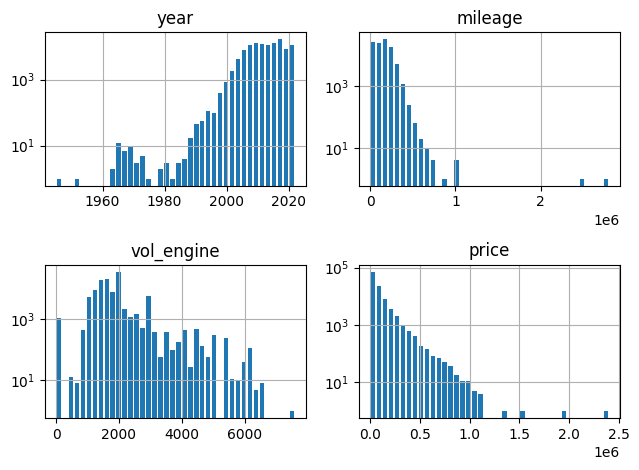

In [336]:
df.hist(column=["year", "mileage", "vol_engine", "price"], bins=40, log=True, rwidth=0.75)
plt.tight_layout()

Данные графики показывают количество машин с определенными атрибутами (год, пробег, объем двигателя, цена) в выбранном датасете.

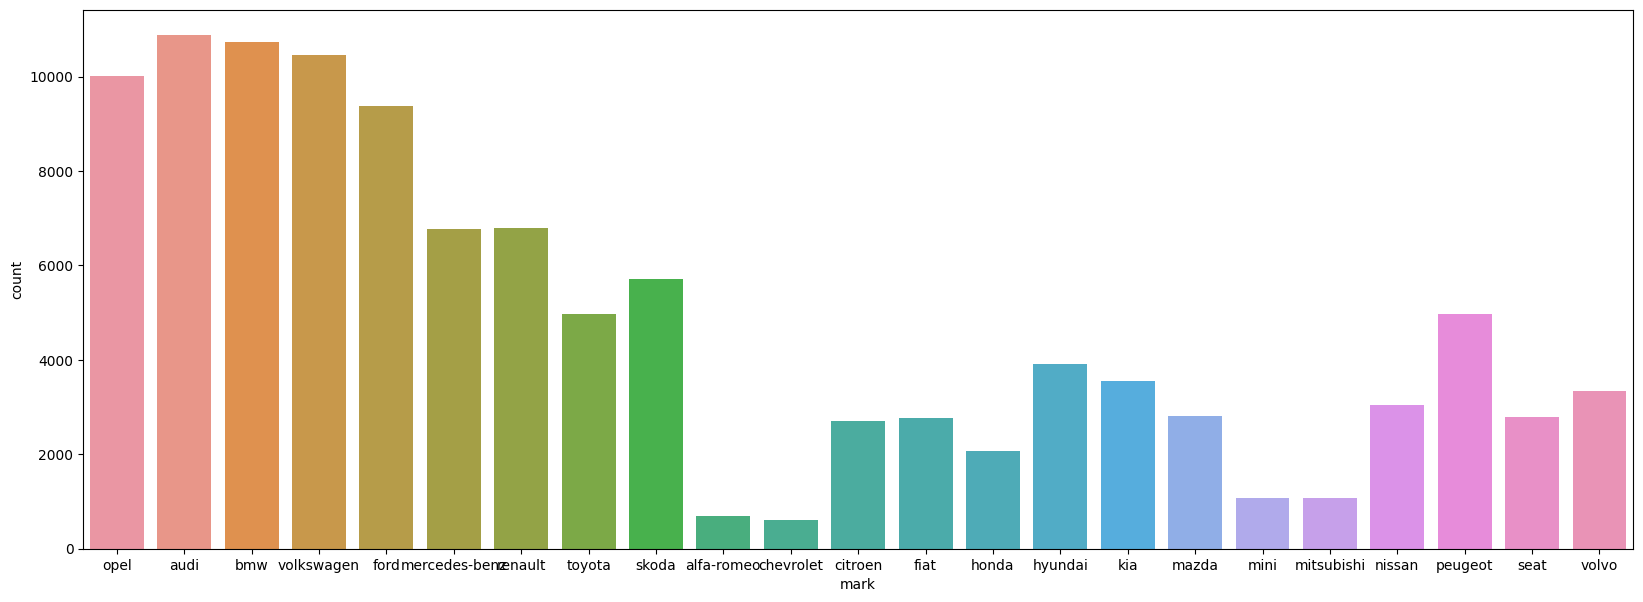

In [337]:
plt.figure(figsize=(20, 7))
sns.countplot(x=df["mark"])
plt.show()

По графику зависимости количества машин от марки можно сделать вывод, что наиболее популярными являются opel, audi, bmw, volkswagen и ford, каждая из перечисленных моделей занимает порядка 10% от общего количества данных.

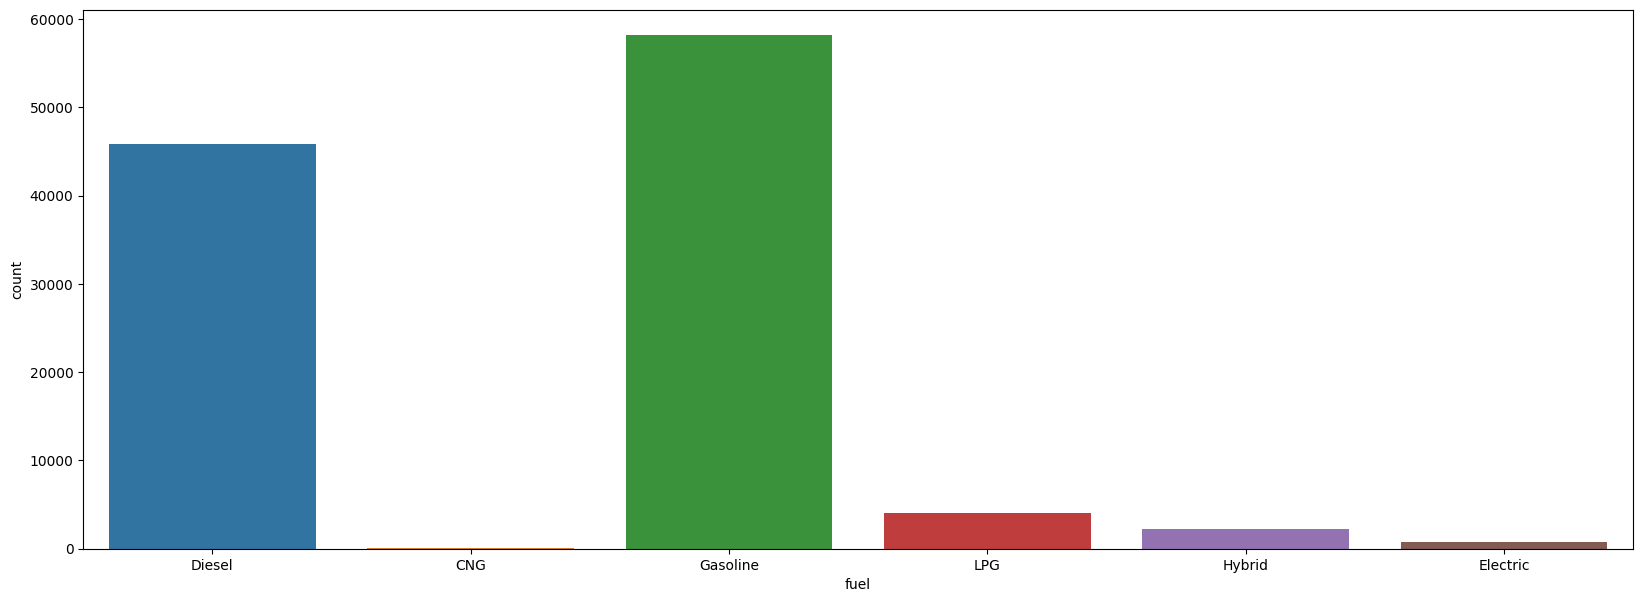

In [338]:
plt.figure(figsize=(20, 7))
sns.countplot(x=df["fuel"])
plt.show()

Наибольшее количество машин из датасета работает на бензине и дизеле.

#### Корреляция

Для анализа зависимостей необходимо преобразовать строковые атрибуты в числа.

In [339]:
LE = LabelEncoder()
df["mark"] = LE.fit_transform(df["mark"])
df["model"] = LE.fit_transform(df["model"])
df["fuel"] = LE.fit_transform(df["fuel"])
df["city"] = LE.fit_transform(df["city"])
df["province"] = LE.fit_transform(df["province"])

print(df.head())

   mark  model  year  mileage  vol_engine  fuel  city  province  price
0    15     89  2015   139568        1248     1  1161         6  35900
1    15     89  2018    31991        1499     1  1365        21  78501
2    15     89  2015   278437        1598     1   300        11  27000
3    15     89  2016    47600        1248     1  1510        11  30800
4    15     89  2014   103000        1400     0  3606        21  35900


Наиболее интересно научиться предсказывать цену автомобилей по остальным признакам. По таблице представленной ниже можно увидеть, что на цену автомобиля наиболее сильно влияют год выпуска, пробег и объем двигателя. При увеличении года выпуска и объема двигателя цена возрастает, а при увеличении пробега цена падает, исходя из знака коэффициента.

<Axes: >

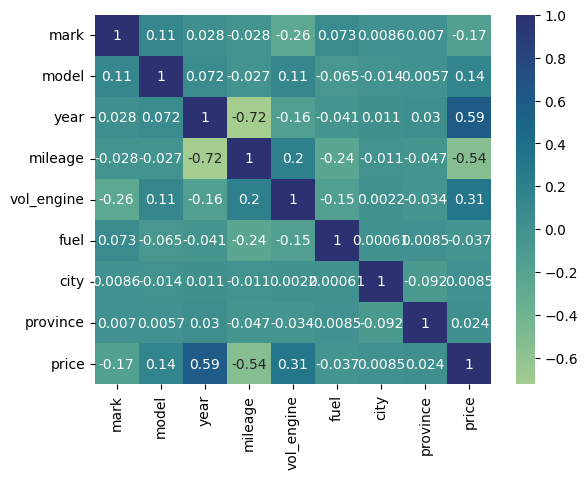

In [340]:
sns.heatmap(df.corr(), annot=True, cmap="crest")

Разобьем данные на обучающую и тестовую выборку случайным образом.

In [341]:
X, y = df.drop(columns="price"), df["price"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

#### Подбор наилучшего количества признаков

Подберем наилучшее количество (и само подмножество) признаков, используя Recursive Feature Elimination (RFE) из sklearn.

In [343]:
rfecv = RFECV(Ridge(), cv=5)
rfecv.fit(X_train, y_train)
selected_fields = X.columns[rfecv.support_]
print("Оставшиеся признаки:", set(selected_fields))
print("Удаленные признаки:", set(X.columns) - set(selected_fields))

X = X[selected_fields]
X_train = X_train[selected_fields]
X_test = X_test[selected_fields]

Оставшиеся признаки: {'year', 'model', 'mark', 'fuel', 'mileage', 'vol_engine', 'province'}
Удаленные признаки: {'city'}


### Реализация алгоритма линейной регрессии

In [344]:
class LinearRegressorAbstract(BaseEstimator, RegressorMixin, abc.ABC):

    def __init__(self, alpha: Real = 1, *, max_iter: Integral = 1000, tol: Real = 1e-4,
                 eta0: Real = 1):
        self.alpha = alpha
        self.max_iter = max_iter
        self.tol = tol
        self.eta0 = eta0

    @abc.abstractmethod
    def _get_X_y_for_GD(self, X, y):
        ...

    def fit(self, X, y):
        self.alpha = check_scalar(self.alpha, "alpha", Real, min_val=0.0)
        self.max_iter = check_scalar(self.max_iter, "max_iter", Integral, min_val=1)
        self.tol = check_scalar(self.tol, "tol", Real, min_val=0.0)
        self.eta0 = check_scalar(self.eta0, "eta0", Real, min_val=0, include_boundaries="neither")

        X, y = check_X_y(X, y, y_numeric=True)
        self.n_features_in_ = X.shape[1]
        X = np.column_stack([X, np.ones(X.shape[0])])

        coef = np.zeros(X.shape[1])
        grad = np.inf
        self.n_iter_ = 0
        while self.n_iter_ < self.max_iter and np.linalg.norm(grad) > self.tol:
            X_subset, y_subset = self._get_X_y_for_GD(X, y)
            pred = X_subset @ coef
            grad = (2 / X_subset.shape[0]) * X_subset.T @ (pred - y_subset) + 2 * self.alpha * np.pad(coef[:-1], (0, 1))
            self.n_iter_ += 1
            coef -= grad * self.eta0 / self.n_iter_

        self.coef_ = coef[:-1]
        self.intercept_ = coef[-1]

        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        return X @ self.coef_ + self.intercept_


class LinearRegressorGD(LinearRegressorAbstract):
    def _get_X_y_for_GD(self, X, y):
        return X, y


class LinearRegressorMBGD(LinearRegressorAbstract):

    def __init__(self, alpha: Real = 1, batch_size: Real = 0.1, *, max_iter: Integral = 1000, tol: Real = 1e-4,
                eta0: Real = 1, random_state=None):
        super().__init__(alpha, max_iter=max_iter, tol=tol, eta0=eta0)
        self.batch_size = batch_size
        self.random_state = random_state

    def _get_X_y_for_GD(self, X, y):
        size = self.batch_size if type(self.batch_size) == int else ceil(len(X) * self.batch_size)
        idx = self.random_state_.randint(len(X), size=size)
        return X[idx, :], y[idx]

    def fit(self, X, y):
        self.batch_size = check_scalar(self.batch_size, "batch_size", (float, int), min_val=0)
        self.random_state_ = check_random_state(self.random_state)
        return super().fit(X, y)


class LinearRegressorSGD(LinearRegressorMBGD):
    def __init__(self, alpha: Real = 1, *, max_iter: Integral = 1000, tol: Real = 1e-4, random_state=None,
                 eta0: Real = 1):
        super().__init__(alpha, 1, max_iter=max_iter, tol=tol, random_state=random_state, eta0=eta0)

### Обучение моделей

In [346]:
pd.options.display.float_format = '{:,.2f}'.format

def train_simple(regressor, estimator_name):    
    model = Pipeline([("scaler", StandardScaler()), ("regressor", regressor)])
    model.fit(X_train, y_train)

    pred = model.predict(X_train)
    mse_train = mean_squared_error(y_train, pred)
    rmse_train = mean_squared_error(y_train, pred, squared=False)
    r2_train = r2_score(y_train, pred)

    pred = model.predict(X_test)
    mse_test = mean_squared_error(y_test, pred)
    rmse_test = mean_squared_error(y_test, pred, squared=False)
    r2_test = r2_score(y_test, pred)

    return [estimator_name, mse_train, mse_test, rmse_train, rmse_test, r2_train, r2_test]

data = []
data.append(train_simple(Ridge(), "Ridge"))
data.append(train_simple(LinearRegressorGD(max_iter=10000), "LinearRegressorGD"))
data.append(train_simple(LinearRegressorMBGD(random_state=50, max_iter=10000), "LinearRegressorMBGD"))
data.append(train_simple(LinearRegressorSGD(random_state=50, max_iter=10000), "LinearRegressorSGD"))

pd.DataFrame(
    data,
    columns=["Estimator", "MSE train", "MSE test", "RMSE train", "RMSE test", "R2 train", "R2 test"]
).set_index("Estimator")

MSE train         MSE test  RMSE train  RMSE test  \
Estimator                                                                      
Ridge               2,946,862,365.61 3,008,041,278.46   54,285.01  54,845.61   
LinearRegressorGD   3,696,066,211.62 3,830,705,767.04   60,795.28  61,892.70   
LinearRegressorMBGD 3,696,165,617.81 3,830,768,011.72   60,796.10  61,893.20   
LinearRegressorSGD  3,691,484,353.62 3,826,830,446.45   60,757.59  61,861.38   

                     R2 train  R2 test  
Estimator                               
Ridge                    0.57     0.57  
LinearRegressorGD        0.46     0.46  
LinearRegressorMBGD      0.46     0.46  
LinearRegressorSGD       0.46     0.46

#### Обучение моделей с кросс-валидацией и подбором гипер-параметров

In [347]:
def train_with_param_cv(estimator, estimator_name, param_grid):
    model = Pipeline([("scaler", StandardScaler()), ("estimator", estimator)])
    param_grid = {f"estimator__{name}": val for name, val in param_grid.items()}
    grid_search = GridSearchCV(
        model,
        param_grid,
        scoring=["neg_mean_squared_error", "neg_root_mean_squared_error", "r2"],
        refit="neg_mean_squared_error",
        return_train_score=True
    )
    grid_search.fit(X, y)

    print(estimator_name)
    print(
        "Лучшие гиперпараметры:",
        {name : val for name, val in grid_search.best_params_.items()}
    )

    result = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_]
    res_data = []
    res_ind = []
    column_names = []
    for i in range(1, 6):
        column_names.append(f"Fold {i}")
    column_names.append("Mean")
    column_names.append("STD")
    
    for score_function, name in [
        ("neg_mean_squared_error", "MSE"),
        ("neg_root_mean_squared_error", "RMSE"),
        ("r2", "R2")
    ]:
        for run_type in ["train", "test"]:
            row = []
            for i in range(5):
                row.append(abs(result[f"split{i}_{run_type}_{score_function}"]))
            row.append(abs(result[f"mean_{run_type}_{score_function}"]))
            row.append(result[f"std_{run_type}_{score_function}"])
            res_data.append(row)
            res_ind.append(f"{name} ({run_type})")
    
    return pd.DataFrame(
        data=res_data,
        index=res_ind,
        columns=column_names
    )

In [361]:
train_with_param_cv(
    Ridge(), "Ridge",
    {"alpha": [0.01, 0.1, 1, 4, 10]}
)

Ridge
Лучшие гиперпараметры: {'estimator__alpha': 0.01}


Fold 1           Fold 2           Fold 3  \
MSE (train)  2,735,180,888.43 2,746,868,734.08 2,485,723,531.02   
MSE (test)   4,096,935,538.57 3,945,984,086.21 4,912,584,931.79   
RMSE (train)        52,298.96        52,410.58        49,857.03   
RMSE (test)         64,007.31        62,817.07        70,089.83   
R2 (train)               0.56             0.54             0.60   
R2 (test)                0.57             0.61             0.49   

                       Fold 4           Fold 5             Mean  \
MSE (train)  3,351,988,378.56 3,402,456,514.77 2,944,443,609.37   
MSE (test)   1,571,358,099.24 1,262,320,793.56 3,157,836,689.88   
RMSE (train)        57,896.36        58,330.58        54,158.70   
RMSE (test)         39,640.36        35,529.15        54,416.75   
R2 (train)               0.58             0.57             0.57   
R2 (test)                0.16             0.51             0.47   

                          STD  
MSE (train)    365,819,460.50  
MSE (test)   1,462,335,063.53  
RMSE (train)         3,358.38  
RMSE (test)         14,023.36  
R2 (train)               0.02  
R2 (test)                0.16

In [349]:
train_with_param_cv(
    LinearRegressorGD(), "LinearRegressorGD",
    {
        "alpha": [0.0001, 0.01, 1],
        "max_iter": [500, 1000, 2000],
        "tol": [1e-4, 1e-5, 1e-6]
    }
)

LinearRegressorGD
Лучшие гиперпараметры: {'estimator__alpha': 0.0001, 'estimator__max_iter': 500, 'estimator__tol': 0.0001}


Fold 1           Fold 2           Fold 3  \
MSE (train)  2,735,185,721.70 2,746,875,559.33 2,485,723,987.66   
MSE (test)   4,097,048,284.80 3,945,510,798.21 4,912,761,493.38   
RMSE (train)        52,299.00        52,410.64        49,857.04   
RMSE (test)         64,008.19        62,813.30        70,091.09   
R2 (train)               0.56             0.54             0.60   
R2 (test)                0.57             0.61             0.49   

                       Fold 4           Fold 5             Mean  \
MSE (train)  3,351,996,961.31 3,402,460,075.36 2,944,448,461.07   
MSE (test)   1,570,871,750.51 1,262,425,588.51 3,157,723,583.08   
RMSE (train)        57,896.43        58,330.61        54,158.75   
RMSE (test)         39,634.22        35,530.63        54,415.49   
R2 (train)               0.58             0.57             0.57   
R2 (test)                0.16             0.51             0.47   

                          STD  
MSE (train)    365,820,859.70  
MSE (test)   1,462,419,289.05  
RMSE (train)         3,358.39  
RMSE (test)         14,024.20  
R2 (train)               0.02  
R2 (test)                0.16

In [350]:
train_with_param_cv(
    LinearRegressorMBGD(), "LinearRegressorMBGD",
    {
        "alpha": [0.0001, 0.01, 1],
        "max_iter": [500, 1000, 2000],
        "tol": [1e-4, 1e-5, 1e-6]
    }
)

LinearRegressorMBGD
Лучшие гиперпараметры: {'estimator__alpha': 0.0001, 'estimator__max_iter': 500, 'estimator__tol': 1e-05}


Fold 1           Fold 2           Fold 3  \
MSE (train)  2,735,244,840.35 2,746,944,013.84 2,485,754,889.98   
MSE (test)   4,095,614,748.96 3,943,428,550.61 4,911,853,331.76   
RMSE (train)        52,299.57        52,411.30        49,857.35   
RMSE (test)         63,996.99        62,796.72        70,084.62   
R2 (train)               0.56             0.54             0.60   
R2 (test)                0.57             0.61             0.49   

                       Fold 4           Fold 5             Mean  \
MSE (train)  3,352,060,503.76 3,402,544,986.99 2,944,509,846.98   
MSE (test)   1,570,859,855.99 1,258,779,808.53 3,156,107,259.17   
RMSE (train)        57,896.98        58,331.34        54,159.31   
RMSE (test)         39,634.07        35,479.29        54,398.34   
R2 (train)               0.58             0.57             0.57   
R2 (test)                0.16             0.51             0.47   

                          STD  
MSE (train)    365,834,372.17  
MSE (test)   1,462,740,865.29  
RMSE (train)         3,358.48  
RMSE (test)         14,033.11  
R2 (train)               0.02  
R2 (test)                0.16

In [351]:
train_with_param_cv(
    LinearRegressorSGD(), "LinearRegressorSGD",
    {
        "alpha": [0.0001, 0.01, 1],
        "max_iter": [10000, 50000],
        "tol": [1e-4, 1e-5, 1e-6]
    }
)

LinearRegressorSGD
Лучшие гиперпараметры: {'estimator__alpha': 0.0001, 'estimator__max_iter': 10000, 'estimator__tol': 1e-05}


Fold 1           Fold 2           Fold 3  \
MSE (train)  2,750,864,767.36 2,767,454,607.33 2,505,551,515.41   
MSE (test)   4,017,096,687.74 3,972,234,204.07 4,946,627,616.25   
RMSE (train)        52,448.69        52,606.60        50,055.48   
RMSE (test)         63,380.57        63,025.66        70,332.27   
R2 (train)               0.56             0.54             0.60   
R2 (test)                0.57             0.61             0.49   

                       Fold 4           Fold 5             Mean  \
MSE (train)  3,401,194,572.64 3,503,427,075.29 2,985,698,507.60   
MSE (test)   1,585,717,626.44 1,279,465,826.32 3,160,228,392.16   
RMSE (train)        58,319.76        59,189.75        54,524.06   
RMSE (test)         39,821.07        35,769.62        54,465.84   
R2 (train)               0.58             0.56             0.57   
R2 (test)                0.15             0.50             0.47   

                          STD  
MSE (train)    393,445,871.63  
MSE (test)   1,456,101,018.66  
RMSE (train)         3,581.29  
RMSE (test)         13,917.65  
R2 (train)               0.02  
R2 (test)                0.16

#### Вывод
Исходя из результатов всех моделей можно сделать вывод, что предсказания цен на автомобили из данного датасета будут не точными.

1. Результаты работы алгоритма Ridge из sklearn с кросс-валидацией и подбором гипер-параметров, не отличаются от работы этого же алгоритма без них.
2. В остальных случаях модели без кросс-валидации и подбора гипер-параметров показали себя незначительно хуже ~0.46 (на тренировочной выборке) и ~0.46 (на тестовой выборке) против ~0.57 и ~0.47 соответственно.
3. Для данного датасета наиболее оптимальным вариантом по времени работы и точности предсказания является модель Ridge из sklearn без кросс-валидации и подбора гипер-параметров.